<a href="https://colab.research.google.com/github/Soomro2023/Project4_CF23Qz0PfJlIm5KH/blob/main/Project4_pretrained_models_solution2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 5.5 MB/s eta 0:00:00


In [3]:
from __future__ import print_function, division
import warnings
warnings.filterwarnings('ignore')

import os
import time
import copy

import pandas as pd
from PIL import Image                             # Python Imaging Library (PIL)
import numpy as np
from tqdm.notebook import tqdm                    # tqdm - Taqadum (arabic) mean "progress" - to create smart progress bar for the loop

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

'''import pytoch dependencies'''

from torchsummary import  summary
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import *
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchmetrics.classification import BinaryF1Score

cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
# Set the random seed for both numpy and pytorch for the getting the same results instead of random
np.random.seed(0)
torch.manual_seed(0)

In [5]:
#Check if the cuda is available otherwise the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device,"is available")

cuda is available


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
data_dir = "/content/drive/MyDrive/images/"

# Resnet

In [8]:
#Resnet transformer
Resnet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# For Resnet
Resnet_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          Resnet_transforms[x])
                  for x in ['training', 'valid']}

Resnet_train_loader = DataLoader(dataset=Resnet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Resnet_val_loader = DataLoader(dataset=Resnet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)

In [10]:
Resnet_datasets['valid'].class_to_idx
idx2class = {v: k for k, v in Resnet_datasets['valid'].class_to_idx.items()}
idx2class

{0: 'flip', 1: 'notflip'}

In [14]:
#We will use resenet18 pretrained model

# load pretrained model
model_resnet = models.resnet18(pretrained=True)

#Get last output feature before the classification layer
num_ftrs = model_resnet.fc.in_features

# Here the size of each output sample is set to 2.
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized, use SGD ooptimizer
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


In [15]:
#Define the training class
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    metric = BinaryF1Score()


    '''define 3 dictionaries which will store the accuracy/epoch,
    F1_score/epochs and loss/epoch for both train and validation sets.'''

    accuracy_stats = {
        'train': [],
        "val": []
        }
    F1score_stats = {
        'train': [],
        "val": []
        }

    loss_stats = {
        'train': [],
        "val": []
        }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloaders=Resnet_train_loader
                # dataset_sizes=train_size
                dataset_sizes = len(Resnet_datasets['training'])
                # print('datasizes:', dataset_sizes)
                model.train()  # Set model to training mode
            else:
                dataloaders=Resnet_val_loader
                # dataset_sizes=Resnet_val_size
                dataset_sizes = len(Resnet_datasets['valid'])
                # print('datasizes:', dataset_sizes)
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_f1 = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # print('loss:', loss)
                    # print(labels.data)

                    # running_f1 = binary_F1(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # print('is:', inputs.size(0))
                # print('rn loss:', running_loss)
                running_corrects += torch.sum(preds == labels.data)
                running_f1 += metric(preds.cpu(), labels.cpu().data)
            if phase == 'train':
                scheduler.step()
            # print('running loss:', running_loss)
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            epoch_f1 = running_f1 / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f} f1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == 'train':
              # print(epoch_acc.item())
              loss_stats['train'].append(epoch_loss)
              accuracy_stats['train'].append(epoch_acc.item())
              F1score_stats['train'].append(epoch_f1.item())


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
              loss_stats['val'].append(epoch_loss)
              accuracy_stats['val'].append(epoch_acc.item())
              F1score_stats['val'].append(epoch_f1.item())


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_stats, accuracy_stats, F1score_stats

In [16]:
model_resnet, loss_stats_resnet, accuracy_stats_resnet, F1score_stats_resnet= train_model(
    model_resnet, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5010 Acc: 0.7551 f1: 0.0920
val Loss: 0.2233 Acc: 0.9208 f1: 0.4542

Epoch 1/19
----------
train Loss: 0.3321 Acc: 0.8601 f1: 0.1065
val Loss: 0.0963 Acc: 0.9625 f1: 0.5292

Epoch 2/19
----------
train Loss: 0.2901 Acc: 0.8783 f1: 0.1095
val Loss: 0.0499 Acc: 0.9833 f1: 0.5250

Epoch 3/19
----------
train Loss: 0.2771 Acc: 0.8880 f1: 0.1101
val Loss: 0.1173 Acc: 0.9708 f1: 0.5042

Epoch 4/19
----------
train Loss: 0.2884 Acc: 0.8899 f1: 0.1106
val Loss: 0.0807 Acc: 0.9708 f1: 0.5292

Epoch 5/19
----------
train Loss: 0.2212 Acc: 0.9168 f1: 0.1138
val Loss: 0.0270 Acc: 0.9875 f1: 0.5292

Epoch 6/19
----------
train Loss: 0.2330 Acc: 0.9071 f1: 0.1118
val Loss: 0.1188 Acc: 0.9542 f1: 0.5292

Epoch 7/19
----------
train Loss: 0.1883 Acc: 0.9275 f1: 0.1157
val Loss: 0.0441 Acc: 0.9833 f1: 0.5250

Epoch 8/19
----------
train Loss: 0.1784 Acc: 0.9275 f1: 0.1149
val Loss: 0.0443 Acc: 0.9792 f1: 0.5250

Epoch 9/19
----------
train Loss: 0.1734 Acc: 0.9308 f1

Text(0.5, 0.98, 'Resnet model')

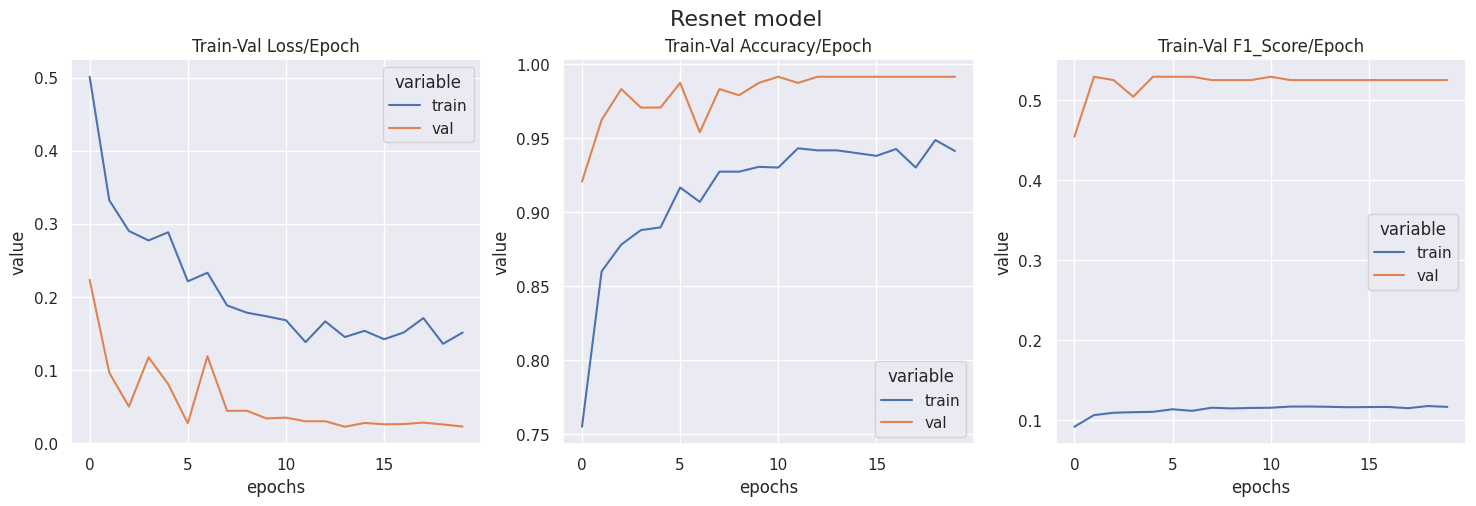

In [17]:
sns.set()
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_df = pd.DataFrame.from_dict(F1score_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats_resnet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[1]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_f1_df, x = "epochs", y="value", hue="variable",  ax=axes[2]).set_title('Train-Val F1_Score/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Loss/Epoch')
fig.suptitle('Resnet model', fontsize=16)

In [18]:
#save the model
torch.save(model_resnet.state_dict(), "/content/drive/MyDrive/images/resnet_model.ckpt")

In [19]:
#This function will be used for all models for testing
def valid_batch_loop(model_test,validloader):

        valid_loss = 0.0
        valid_acc = 0.0
        final_y_pred_list=[]
        final_y_true_list=[]
        for images,labels in tqdm(validloader):

            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            logits = model_test(images)
            acc,y_pred_list,y_true_list=binary_acc_test(logits,labels)
            final_y_pred_list.extend(y_pred_list)
            final_y_true_list.extend(y_true_list)
            valid_acc = valid_acc + acc

        return valid_acc / len(validloader),final_y_pred_list,final_y_true_list

In [20]:
#This function calculate the accuracy and 2 lists, one of predictions and the other for true labels for each input.
def binary_acc_test(y_pred, y_test):
    y_pred_list=[]
    y_true_list=[]
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    y_pred_list.append(y_pred_tags.cpu().numpy())
    y_true_list.append(y_test.cpu().numpy())
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc,y_pred_list,y_true_list

In [23]:
#load the best model to our device
resnet_model = models.resnet18(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)
resnet_model = resnet_model.to(device)
# resnet_model = model_resnet().to(device)
resnet_model.load_state_dict(torch.load('/content/drive/MyDrive/images/resnet_model.ckpt'))

<All keys matched successfully>

In [24]:
#define test dataset and test dataloader
resnet_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/testing/', transform=Resnet_transforms['valid'])
resnet_test_loader = DataLoader(dataset=resnet_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [25]:
#define the eval mode
resnet_model.eval()
#Check the test accuracy
avg_test_acc_resnet,final_y_pred_list_resnet,final_y_true_list_resnet = valid_batch_loop(resnet_model,resnet_test_loader)
print("Test Accuracy of Resnet: {}".format(avg_test_acc_resnet))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Accuracy of Resnet: 99.1624755859375


In [26]:
report_resnet = classification_report([i[0] for i in final_y_true_list_resnet], [i[0] for i in final_y_pred_list_resnet],digits=4)

In [27]:
print('\033[1;32m Classification report of Resnet model on test dataset \n')

print('\033[1;34m', report_resnet)

 Classification report of Resnet model on test dataset 

               precision    recall  f1-score   support

           0     1.0000    0.9828    0.9913       290
           1     0.9840    1.0000    0.9919       307

    accuracy                         0.9916       597
   macro avg     0.9920    0.9914    0.9916       597
weighted avg     0.9918    0.9916    0.9916       597



Text(0.5, 0.98, 'Confusion matrix of Resnet model')

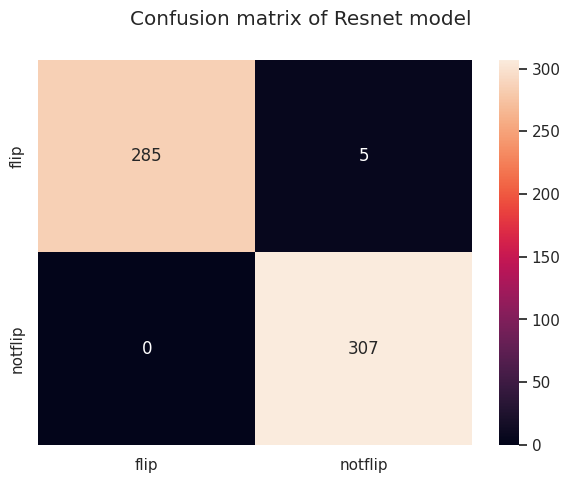

In [28]:
confusion_matrix_df_resnet = pd.DataFrame(confusion_matrix(final_y_true_list_resnet, final_y_pred_list_resnet)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix_df_resnet, annot=True, ax=ax, fmt='g')
fig.suptitle('Confusion matrix of Resnet model')

# Densenet

In [29]:
#DenseNet transformer
Densenet_transforms = {
    'training': transforms.Compose([
        transforms.CenterCrop(1080),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
# For Densenet
Densenet_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          Densenet_transforms[x])
                  for x in ['training', 'valid']}

Densenet_train_loader = DataLoader(dataset=Densenet_datasets['training'], shuffle=True, batch_size=8, num_workers=4)
Densenet_val_loader = DataLoader(dataset=Densenet_datasets['valid'], shuffle=True, batch_size=1, num_workers=4)

In [31]:
#Load the pretrained densenet121 model
model_densenet = models.densenet121(pretrained=True)

#Get last output feature before the classification layer
num_ftrs = model_densenet.classifier.in_features

# Here the size of each output sample is set to 2.
model_densenet.classifier = nn.Linear(num_ftrs, 2)

model_densenet = model_densenet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized, use SGD ooptimizer
optimizer = optim.SGD(model_densenet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s] 


In [32]:
model_densenet, loss_stats_densenet, accuracy_stats_densenet, F1score_stats_densenet= train_model(
    model_densenet, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.4776 Acc: 0.7658 f1: 0.0937
val Loss: 0.1224 Acc: 0.9625 f1: 0.5292

Epoch 1/19
----------
train Loss: 0.3198 Acc: 0.8606 f1: 0.1071
val Loss: 0.0710 Acc: 0.9708 f1: 0.5167

Epoch 2/19
----------
train Loss: 0.3222 Acc: 0.8773 f1: 0.1081
val Loss: 0.2050 Acc: 0.9375 f1: 0.4667

Epoch 3/19
----------
train Loss: 0.2471 Acc: 0.9075 f1: 0.1125
val Loss: 0.0685 Acc: 0.9833 f1: 0.5292

Epoch 4/19
----------
train Loss: 0.2795 Acc: 0.8787 f1: 0.1085
val Loss: 0.0951 Acc: 0.9708 f1: 0.5292

Epoch 5/19
----------
train Loss: 0.2056 Acc: 0.9099 f1: 0.1129
val Loss: 0.0582 Acc: 0.9792 f1: 0.5125

Epoch 6/19
----------
train Loss: 0.1980 Acc: 0.9196 f1: 0.1143
val Loss: 0.0353 Acc: 0.9833 f1: 0.5250

Epoch 7/19
----------
train Loss: 0.1554 Acc: 0.9382 f1: 0.1164
val Loss: 0.0303 Acc: 0.9875 f1: 0.5250

Epoch 8/19
----------
train Loss: 0.1322 Acc: 0.9498 f1: 0.1180
val Loss: 0.0262 Acc: 0.9875 f1: 0.5250

Epoch 9/19
----------
train Loss: 0.1549 Acc: 0.9391 f1

Text(0.5, 0.98, 'Densenet model')

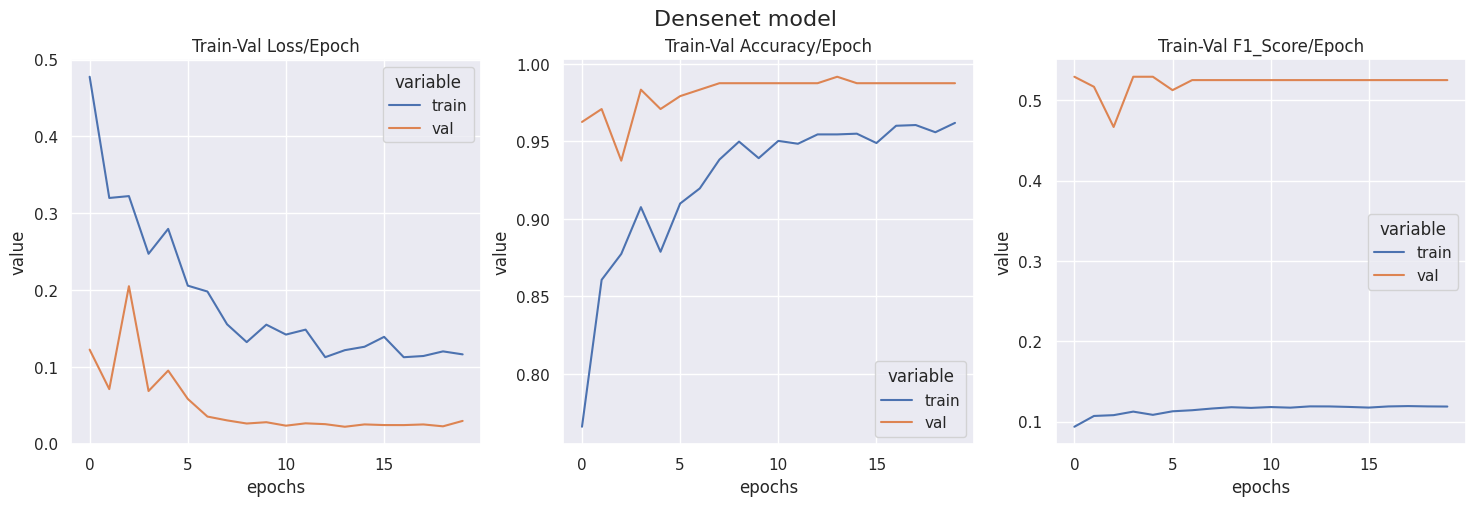

In [33]:
sns.set()
train_val_acc_densenet_df = pd.DataFrame.from_dict(accuracy_stats_densenet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_densenet_df = pd.DataFrame.from_dict(F1score_stats_densenet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_densenet_df = pd.DataFrame.from_dict(loss_stats_densenet).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
sns.lineplot(data=train_val_acc_densenet_df, x = "epochs", y="value", hue="variable",  ax=axes[1]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_f1_densenet_df, x = "epochs", y="value", hue="variable",  ax=axes[2]).set_title('Train-Val F1_Score/Epoch')
sns.lineplot(data=train_val_loss_densenet_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Loss/Epoch')
fig.suptitle('Densenet model', fontsize=16)

In [34]:
#save the model
torch.save(model_densenet.state_dict(), "/content/drive/MyDrive/images/densenet_model.ckpt")

In [35]:
#load the best model to our device
densenet_model = models.densenet121(pretrained=True)
num_ftrs = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_ftrs, 2)
model_densenet = densenet_model.to(device)
#load the best model to use it for testing
densenet_model.load_state_dict(torch.load('/content/drive/MyDrive/images/densenet_model.ckpt'))

<All keys matched successfully>

In [36]:
#define test dataset and test dataloader
densenet_test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/images/testing/', transform=Densenet_transforms['valid'])
densenet_test_loader = DataLoader(dataset=densenet_test_dataset, shuffle=True, batch_size=1, num_workers=4)

In [37]:
#define the eval mode
densenet_model.eval()
#Check the test accuracy
avg_test_acc_densenet,final_y_pred_list_densenet,final_y_true_list_densenet = valid_batch_loop(densenet_model,densenet_test_loader)
print("Test Accuracy of Densenet: {}".format(avg_test_acc_densenet))

  0%|          | 0/597 [00:00<?, ?it/s]

Test Accuracy of Densenet: 99.8324966430664


In [38]:
report_densenet = classification_report([i[0] for i in final_y_true_list_densenet], [i[0] for i in final_y_pred_list_densenet],digits=4)

In [39]:
print('\033[1;32m Classification report of Densenet model on test dataset \n')
print('\033[1;34m', report_densenet)

 Classification report of Densenet model on test dataset 

               precision    recall  f1-score   support

           0     1.0000    0.9966    0.9983       290
           1     0.9968    1.0000    0.9984       307

    accuracy                         0.9983       597
   macro avg     0.9984    0.9983    0.9983       597
weighted avg     0.9983    0.9983    0.9983       597



In [40]:
confusion_matrix_df_densenet = pd.DataFrame(confusion_matrix(final_y_true_list_densenet, final_y_pred_list_densenet)).rename(columns=idx2class, index=idx2class)
# fig, ax = plt.subplots(figsize=(7,5))
# sns.heatmap(confusion_matrix_df_densenet, annot=True, ax=ax, fmt='g')
# fig.suptitle('Confusion matrix of Densenet model')

# Results comparison

		Comparision between Resnet and with Densenet models 

--------------------------------------------------------------------------------
   model              |   Accuracy    |   Precision  |  recall   |   F1-score
--------------------------------------------------------------------------------
   Resnet18           |    99.16 %    |    99.18 %   |   99.16 % |   99.16 % 
   Densnet121         |    99.83 %    |    99.83 %   |   99.83 % |   99.83 % 





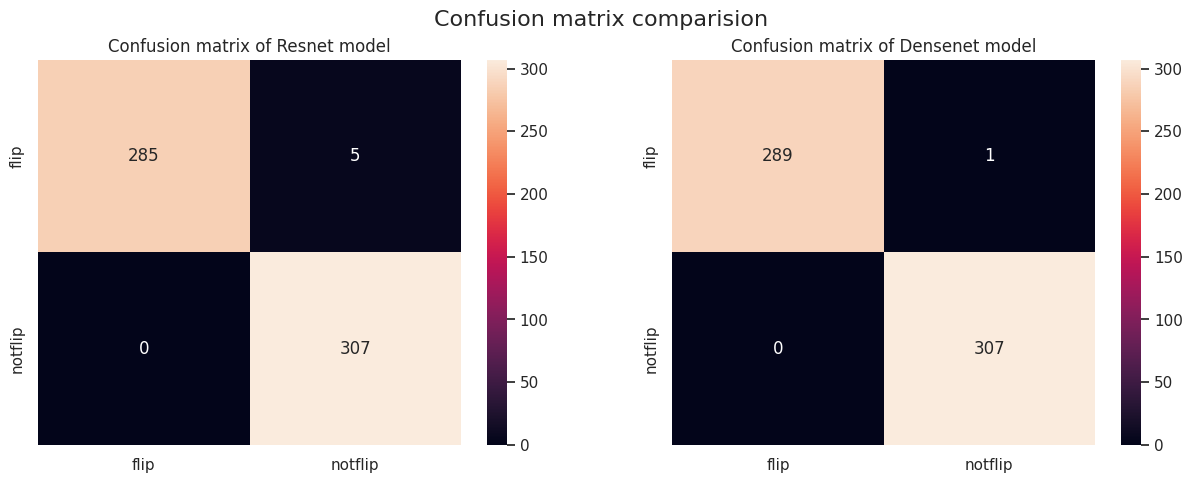

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.heatmap(data=confusion_matrix_df_resnet, annot=True, fmt='g', ax=axes[0]).set_title('Confusion matrix of Resnet model')
sns.heatmap(data=confusion_matrix_df_densenet, annot=True, fmt='g', ax=axes[1]).set_title('Confusion matrix of Densenet model')
fig.suptitle('Confusion matrix comparision', fontsize=16)

print("\t\tComparision between Resnet and with Densenet models \n")
print('-'*80)
print('   model              |   Accuracy    |   Precision  |  recall   |   F1-score')
print('-'*80)
print("   Resnet18           |    99.16 %    |    99.18 %   |   99.16 % |   99.16 % ")
print("\033[1;34m   Densnet121         |    99.83 %    |    99.83 %   |   99.83 % |   99.83 % \n\n\n")

# Conclusion

In this second solution, I use two pretrained models: 1. Resnet18 and 2. Densenet121. Results demonstrate that the Densenet121 model has produced a better f1-score 99.83 % than Resnet (99.16 %). Comparing confusion metrics of both models, the Densnet model has only one false positive and zero false negative. This shows that the Densenet model outperforms for page flip prediction.